In [1]:
# Marina Reggiani-Guzzo
# September 20, 2021

# Hello, this is the code that contains the most up-to-date version of my code.
# Please keep it up-to-date and commented as much as you can, so it is self-explanatory
# for people and for yourself in the future. You'll thank me for that, believe me! :)

## Functions (keep it collapsed!)

In [2]:
# =============== #
#                 #
#    LIBRARIES    #
#                 #
# =============== #

import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot3 as uproot

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, f1_score

import xgboost
from xgboost import XGBClassifier

pd.options.display.max_columns = None 

# ====================== #
#                        #
#    CREATE DATAFRAME    #
#                        #
# ====================== #

def create_dataframe(file, family):
    
    # ------------ #
    # import trees #
    # ------------ # 
    
    T_pot = uproot.open(file)['wcpselection/T_pot']
    T_KINE = uproot.open(file)['wcpselection/T_KINEvars']
    T_BDT = uproot.open(file)['wcpselection/T_BDTvars']
    T_PFeval = uproot.open(file)['wcpselection/T_PFeval']
    T_eval = uproot.open(file)['wcpselection/T_eval']
    
    # --- create reco dataframes
    df_pot_reco    = T_pot.pandas.df(pot_vars_reco, flatten=False)
    df_KINE_reco   = T_KINE.pandas.df(kine_vars_reco, flatten=False)
    df_BDT_reco    = T_BDT.pandas.df(bdt_vars_reco, flatten=False)
    df_PFeval_reco = T_PFeval.pandas.df(pfeval_vars_reco, flatten=False)
    df_eval_reco   = T_eval.pandas.df(eval_vars_reco, flatten=False)    
    
    df = pd.concat([df_KINE_reco, df_BDT_reco, df_PFeval_reco, df_eval_reco], axis=1)
    
    # --- create truth dataframes
    if((family=='MC') | (family=='NUE')):
        df_pot_true    = T_pot.pandas.df(pot_vars_true, flatten=False)
        df_KINE_true   = T_KINE.pandas.df(kine_vars_true, flatten=False)
        df_BDT_true    = T_BDT.pandas.df(bdt_vars_true, flatten=False)
        df_PFeval_true = T_PFeval.pandas.df(pfeval_vars_true, flatten=False)
        df_eval_true   = T_eval.pandas.df(eval_vars_true, flatten=False)
        
        df = pd.concat([df, df_KINE_true, df_BDT_true, df_PFeval_true, df_eval_true], axis=1)
        
    # ----------------------------------------------------------------- #
    #  fix weight_cv and weight_spline (only overlay and intrinsic nue) #
    # ----------------------------------------------------------------- #
    
    if((family=='MC') | (family=='NUE')):
        df['weight_cv'] = np.where((df.weight_cv <= 0), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv > 30), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv == np.nan), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv == np.inf), 1, df.weight_cv)
        df['weight_cv'] = np.where((df['weight_cv'].isna()), 1, df.weight_cv)
        df['weight_spline'] = np.where((df.weight_spline <= 0), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline > 30), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline == np.nan), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline == np.inf), 1, df.weight_spline)
        df['weight_spline'] = np.where((df['weight_spline'].isna()), 1, df.weight_spline)
                
    # ------------- #
    # fix nue_score #
    # ------------- #
    
    df['nue_score'] = np.where((df.nue_score == np.inf), 16, df.nue_score)
    df['nue_score'] = np.where((df.nue_score == -np.inf), -16, df.nue_score)   
    
    # ------------------------ #
    # calculate POT and weight #
    # ------------------------ #
    
    POT_tot = 0
    W_ = 1
    
    if((family=='MC') | (family=='NUE')): 
        POT_tot = sum(df_pot_reco.pot_tor875)
        if(POT_tot!=0): W_ = POT_data/POT_tot # <--- up to here calculated
        elif(POT_tot==0): W_ = 1
        df.loc[:,'weight_genie'] = df['weight_cv']*df['weight_spline']
        df.loc[:,'weight'] = [W_]*df.shape[0]*df['weight_genie']
        
    elif(family=='DATA'): 
        POT_tot = POT_data
        W_ = 1
        df.loc[:,'weight'] = [W_]*df.shape[0]
        
    elif(family=='EXT'): 
        POT_tot = POT_ext
        W_ = (POT_data/POT_tot)*0.98
        df.loc[:,'weight'] = [W_]*df.shape[0]
        
    print('[%s] POT %5.2e' % (family,POT_tot))

    # ------------------- #
    # add extra variables #
    # ------------------- #
    
    df = calc_costheta(df)
    
    if((family=='MC') | (family=='NUE')): 
        # new variables that depend on true information should be here
        df = calc_vtx_reco_true_dist(df)    
    
    # -------------------------------------- #
    # delete dataframes to save memory space #
    # -------------------------------------- #
    
    del df_pot_reco
    del df_KINE_reco
    del df_BDT_reco 
    del df_PFeval_reco
    del df_eval_reco
    
    if((family=='MC') | (family=='NUE')):
        del df_pot_true
        del df_KINE_true
        del df_BDT_true
        del df_PFeval_true
        del df_eval_true    

    return df

# ========================================= #
#                                           #
#    FUNCTIONS TO CREATE EXTRA VARIABLES    #
#                                           #
# ========================================= #

def calc_costheta(df):
    
    # position of the NuMI target
    # those values are manually added to the lines below
    # if you want to change them, make sure you also update the lines below!!
    v_targ_uboone = [-31387.58422, -3316.402543, -60100.2414]

    # take the vector from the NuMI target to the neutrino vertex
    df.eval('vec_targ_vtx_X = reco_nuvtxX - (-31387.58422)', inplace=True)
    df.eval('vec_targ_vtx_Y = reco_nuvtxY - (-3316.402543)', inplace=True)
    df.eval('vec_targ_vtx_Z = reco_nuvtxZ - (-60100.2414)', inplace=True)
    
    # get reco shower vector (workaround that is working, for some reason I can't access it if I don't do this workaround, maybe it's somethind to do with the name containing [ ])
    df.loc[:,'shower_momentum_X'] = df["reco_showerMomentum[0]"]
    df.loc[:,'shower_momentum_Y'] = df["reco_showerMomentum[1]"]
    df.loc[:,'shower_momentum_Z'] = df["reco_showerMomentum[2]"]
    df.loc[:,'shower_energy'] = df["reco_showerMomentum[3]"]
    
    # calculate the norm of the vectors
    df.eval('norm_vec_targ_vtx = sqrt(vec_targ_vtx_X**2 + vec_targ_vtx_Y**2 + vec_targ_vtx_Z**2)', inplace=True)
    df.eval('norm_vec_shower = sqrt(shower_momentum_X**2 + shower_momentum_Y**2 + shower_momentum_Z**2)', inplace=True)
    
    # calculate cos_theta
    df.eval('cos_theta = ((vec_targ_vtx_X * shower_momentum_X) + (vec_targ_vtx_Y * shower_momentum_Y) + (vec_targ_vtx_Z * shower_momentum_Z) )/(norm_vec_targ_vtx * norm_vec_shower)', inplace=True)

    return df

def calc_vtx_reco_true_dist(df):
    df_copy = df.copy()
    df_copy.eval('dist_vtxX = reco_nuvtxX - truth_corr_nuvtxX', inplace=True)
    df_copy.eval('dist_vtxY = reco_nuvtxY - truth_corr_nuvtxY', inplace=True)
    df_copy.eval('dist_vtxZ = reco_nuvtxZ - truth_corr_nuvtxZ', inplace=True)
    df_copy.eval('dist_vtx = sqrt(dist_vtxX**2 + dist_vtxY**2 + dist_vtxZ**2)', inplace=True)
    return df_copy

def calc_particle_multiplicity(filename):

    # --- open file and variables
    
    pfeval_particle = ['reco_mother','reco_pdg','reco_Ntrack']
    T_PFeval = uproot.open(filename)['wcpselection/T_PFeval']
    DF = T_PFeval.pandas.df(pfeval_particle, flatten=True)
    
    # --- queries to split into different variables
    
    df_Neutron = DF.query('((reco_pdg==2112) | (reco_pdg==-2112)) & reco_mother==0')
    df_Neutron['countNeutron'] = df_Neutron.groupby(['entry'])['reco_pdg'].transform('count')

    df_Muon = DF.query('((reco_pdg==13) | (reco_pdg==-13)) & reco_mother==0')
    df_Muon['countMuon'] = df_Muon.groupby(['entry'])['reco_pdg'].transform('count')

    df_Kaon = DF.query('((reco_pdg==321) | (reco_pdg==-321)) & reco_mother==0')
    df_Kaon['countKaon'] = df_Kaon.groupby(['entry'])['reco_pdg'].transform('count')

    df_Pion = DF.query('((reco_pdg==211) | (reco_pdg==-211)) & reco_mother==0')
    df_Pion['countNeutron'] = df_Pion.groupby(['entry'])['reco_pdg'].transform('count')

    df_Proton = DF.query('((reco_pdg==2212) | (reco_pdg==-2212)) & reco_mother==0')
    df_Proton['countProton'] = df_Proton.groupby(['entry'])['reco_pdg'].transform('count')

    df_Gamma = DF.query('((reco_pdg==22) | (reco_pdg==-22)) & reco_mother==0')
    df_Gamma['countGamma'] = df_Gamma.groupby(['entry'])['reco_pdg'].transform('count')

    df_Electron = DF.query('((reco_pdg==11) | (reco_pdg==-11)) & reco_mother==0')
    df_Electron['countElectron'] = df_Electron.groupby(['entry'])['reco_pdg'].transform('count')
    
    # --- concat everything together
    
    df_concat = pd.concat([DF,df_Neutron,df_Muon,df_Kaon,df_Pion,df_Proton,df_Gamma,df_Electron], axis=1)
    df_concat = df_concat.loc[:,~df_concat.columns.duplicated()]
    
    # --- create an extra column with the max number in the count... column
    
    df_concat['Num_Neutron'] = df_concat.groupby(['entry'])['countNeutron'].transform(max)
    df_concat['Num_Muon'] = df_concat.groupby(['entry'])['countMuon'].transform(max)
    df_concat['Num_Kaon'] = df_concat.groupby(['entry'])['countKaon'].transform(max)
    df_concat['Num_Proton'] = df_concat.groupby(['entry'])['countProton'].transform(max)
    df_concat['Num_Gamma'] = df_concat.groupby(['entry'])['countGamma'].transform(max)
    df_concat['Num_Electron'] = df_concat.groupby(['entry'])['countElectron'].transform(max)
    
    # --- get the first subentry only --> the same as unflatten the dataframe
    
    df_concat.groupby('entry').first()
    
    # --- create the final dataframe with the columns that we want
    
    df_final = df_concat[['Num_Neutron','Num_Muon','Num_Kaon','Num_Proton','Num_Gamma','Num_Electron']].groupby('entry').first()
    df_final = df_final.fillna(0)
    
    # --- return final dataframe
    
    return df_final

# ====================== #
#                        #
#     SELECTION CUTS     #
#                        #
# ====================== #

def apply_gen_nu_selection(df):    
    # the generic neutrino selection guarantees that there is a reconstructed neutrino
    df_ = df[df.numu_cc_flag >= 0]
    return df_

def apply_inFV(df):
    dist = 3 # distance from the boundaries
    df_ = df[((df.reco_nuvtxX>(tpc_xmin+dist)) & (df.reco_nuvtxX<(tpc_xmax-dist))) &
             ((df.reco_nuvtxY>(tpc_ymin+dist)) & (df.reco_nuvtxY<(tpc_ymax-dist))) &
             ((df.reco_nuvtxZ>(tpc_zmin+dist)) & (df.reco_nuvtxZ<(tpc_zmax-dist)))]    
    return df_

def apply_showerCut(df):    
    # this cut guarantees that there is a reconstructed shower
    # shower_vtxX = shower_vtxY = shower_vtxZ = shower_energy = -1 for events without a reconstructed shower
    # so it is safe to select shower_energy!=-1 since shower_energy==-1 is not a physical quantity
    df_ = df[df.shower_energy!=-1] 
    return df_

# ======================== #
#                          #
#   APPLY SELECTION CUTS   #
#                          #
# ======================== #

def applyCuts(label, dfData, dfEXT, dfIntrinsicNue, dfOverlay, count):
    
    print('\n---------- Applying: %s\n' % label)
    
    # ----- apply the cuts to the input dataframes
    
    if(label=='None'):
        # take the dataframes as they are (raw entries)
        df_data = dfData
        df_ext = dfEXT
        df_intrinsic_nue = dfIntrinsicNue
        df_overlay = dfOverlay        
    elif(label=='GenNuSelection'):
        # guarantees a reconstructed neutrino
        df_data = apply_gen_nu_selection(dfData)
        df_ext = apply_gen_nu_selection(dfEXT)
        df_intrinsic_nue = apply_gen_nu_selection(dfIntrinsicNue)
        df_overlay = apply_gen_nu_selection(dfOverlay)
    elif(label=='inFV'):
        # neutrino reconstructed vertex inFV
        df_data = apply_inFV(dfData)
        df_ext = apply_inFV(dfEXT)
        df_intrinsic_nue = apply_inFV(dfIntrinsicNue)
        df_overlay = apply_inFV(dfOverlay)
    elif(label=='ShowerCut'):
        # guarantees a reconstructed shower 
        # important for my analysis as I depend 
        df_data = apply_showerCut(dfData)
        df_ext = apply_showerCut(dfEXT)
        df_intrinsic_nue = apply_showerCut(dfIntrinsicNue)
        df_overlay = apply_showerCut(dfOverlay)
    # if you want to include a new cut, simply add it to the list below, to the commented out block
    #elif(label=='NewCut'): 
        #df_data = apply_newcut(dfData)
        #df_ext = apply_newcut(dfEXT)
        #df_intrinsic_nue = apply_newcut(dfIntrinsicNue)
        #df_overlay = apply_newcut(dfOverlay)
        
    # print the updated number of entries after the cut
    #print('%s' % label)
    #print('[DATA] %i entries' % len(df_data))
    #print('[EXT] %i entries' % len(df_ext))
    #print('[NUE] %i entries' % len(df_intrinsic_nue))
    #print('[MC] %i entries' % len(df_overlay))
    #print('')
    
    # ----- plot quantities throughout the cuts
    count = save_info_throughout_the_cuts(df_data, df_ext, df_intrinsic_nue, df_overlay, label, count)
    
    # make plots
    plots_for_SelectionCuts(df_data, df_ext, df_intrinsic_nue, df_overlay, label)
        
    # return the updated dataframes
    return df_data, df_ext, df_intrinsic_nue, df_overlay, count 

def save_info_throughout_the_cuts(df_data, df_ext, df_intrinsic_nue, df_overlay, cut, count):
    
    # what kind of entries do you want to plot?
    kind_nentries = 1  # 1=weighted, 2=absolute number
    
    if(kind_nentries==1):
        throughout_the_cuts_nentries_data.append(sum(df_data.weight))
        throughout_the_cuts_nentries_ext.append(sum(df_ext.weight))
        throughout_the_cuts_nentries_intrinsic_nue.append(sum(df_intrinsic_nue.weight))
        throughout_the_cuts_nentries_overlay.append(sum(df_overlay.weight))
    elif(kind_nentries==2):
        throughout_the_cuts_nentries_data.append(len(df_data))
        throughout_the_cuts_nentries_ext.append(len(df_ext))
        throughout_the_cuts_nentries_intrinsic_nue.append(len(df_intrinsic_nue))
        throughout_the_cuts_nentries_overlay.append(len(df_overlay))
    
    # used for all variables as the x axis
    throughout_the_cuts_nentries_x.append(count)
    throughout_the_cuts_nentries_label.append(cut)
    count = count + 1 # don't touch it
    
    return count

# ======================================== #
#                                          #
#   LIST OF PLOTS FOR THE SELECTION CUTS   #
#                                          #
# ======================================== #

def plots_for_SelectionCuts(df_data, df_ext, df_intrinsic_nue, df_overlay, label):
    
    # plot 
    
    # this function plots the DATA/MC comparison for the variables below at every stage of the selection cuts
    # stacked histograms
       
    dist = 15
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "reco_nuvtxX", "plots/%s_nuvtxX" % label, "Reco neutrino Vertex X [cm]", tpc_xmin-dist, tpc_xmax+dist, 25, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "reco_nuvtxY", "plots/%s_nuvtxY" % label, "Reco neutrino Vertex Y [cm]", tpc_ymin-dist, tpc_ymax+dist, 25, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "reco_nuvtxZ", "plots/%s_nuvtxZ" % label, "Reco neutrino Vertex Z [cm]", tpc_zmin-dist, tpc_zmax+dist, 25, POT_data)
    
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "flash_time", "plots/%s_flash_time" % label, r"Flash Time [$\mu$s]", 4, 18, 50, POT_data)
    
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "cos_theta", "plots/%s_costheta" % label, r"cos($\theta$)", -1.2, 1.2, 25, POT_data)
    
def plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, var, filename, xaxis, xmin, xmax, nbins, POT_DATA):
    
    print('Plotting stacked histogram: %s' % xaxis)
    
    plt.close() # close figure to save memory    
    
    # ----- restrict the dataframes to the range that is going to be displayed 
    
    df_overlay = df_overlay[(df_overlay[var]>=xmin) & (df_overlay[var]<=xmax)]
    df_intrinsic_nue = df_intrinsic_nue[(df_intrinsic_nue[var]>=xmin) & (df_intrinsic_nue[var]<=xmax)]
    df_data = df_data[(df_data[var]>=xmin) & (df_data[var]<=xmax)]
    df_ext = df_ext[(df_ext[var]>=xmin) & (df_ext[var]<=xmax)]
        
    # ----- get the number of entries
    
    n_overlay = len(df_overlay)
    n_intrinsic_nue = len(df_intrinsic_nue)
    n_data = len(df_data)
    n_ext = len(df_ext)
    
    # ----- check if the events are uniquely classified
    #check_classification_multiplicity(df_overlay, 'Overlay')
    
    # ----- get TRUE topologies
    
    # cosmic
    df_cosmic = isCosmic(df_overlay)
    n_cosmic = len(df_cosmic)
    df_overlay = delete_dataframe(df_overlay,df_cosmic) # delete overlay and bad reconstructed events

    # outFV
    df_outFV = isOutFV(df_overlay)
    n_outFV = len(df_outFV)
    df_overlay = delete_dataframe(df_overlay,df_outFV) # exclude events outside the FV

    # numuCCpi0
    df_numuCCpi0 = isNumuCCpi0(df_overlay)
    n_numuCCpi0 = len(df_numuCCpi0)

    # numuCC
    df_numuCC = isNumuCC(df_overlay)
    n_numuCC = len(df_numuCC)

    # NCpi0
    df_ncpi0 = isNCpi0(df_overlay)
    n_ncpi0 = len(df_ncpi0)

    # NC
    df_nc = isNC(df_overlay)
    n_nc = len(df_nc)
    
    # nueCC
    # not used for the stacked histogram, only checking if all events
    df_nueCC = isNueCC(df_overlay)
    n_nueCC = len(df_nueCC)
    
    # nuebarCC
    df_nuebarCC = isNuebarCC(df_overlay)
    n_nuebarCC = len(df_nuebarCC)

    #print('\nOverlay (%i entries)' % n_overlay)
    #print('Cosmic    %10i' % n_cosmic)
    #print('outFV     %10i' % n_outFV)
    #print('NumuCCpi0 %10i' % n_numuCCpi0)
    #print('NumuCC    %10i' % n_numuCC)
    #print('NCpi0     %10i' % n_ncpi0)
    #print('NC        %10i' % n_nc)
    #print('NueCC     %10i' % n_nueCC)
    #print('NuebarCC  %10i' % n_nuebarCC)
    #print('Total     %10i' % (n_cosmic + n_outFV + n_numuCCpi0 + n_numuCC + n_ncpi0 + n_nc + n_nueCC + n_nuebarCC))
    
    # nueCC
    df_nueCC = isNueCC(df_intrinsic_nue)
    n_nueCC = len(df_nueCC)

    # nuebarCC
    df_nuebarCC = isNuebarCC(df_intrinsic_nue)
    n_nuebarCC = len(df_nuebarCC)
    
    #print('\nIntrinsic Nue (%i entries)' % n_intrinsic_nue)
    #print('NueCC     %10i' % n_nueCC)
    #print('NuebarCC  %10i' % n_nuebarCC) 
    #print('Total     %10i' % (n_nueCC + n_nuebarCC))
    
    # get entries
    hist_list = [isTopo_reco(df_cosmic)[var],
                 isTopo_reco(df_outFV)[var],
                 isTopo_reco(df_numuCCpi0)[var],
                 isTopo_reco(df_numuCC)[var],
                 isTopo_reco(df_ncpi0)[var],
                 isTopo_reco(df_nc)[var],
                 isTopo_reco(df_nueCC)[var],
                 isTopo_reco(df_nuebarCC)[var],
                 isTopo_reco(df_ext)[var]]

    hist_data = isTopo_reco(df_data)[var]

    # weights
    w_list = [isTopo_reco(df_cosmic).weight,
              isTopo_reco(df_outFV).weight,
              isTopo_reco(df_numuCCpi0).weight,
              isTopo_reco(df_numuCC).weight,
              isTopo_reco(df_ncpi0).weight,
              isTopo_reco(df_nc).weight,
              isTopo_reco(df_nueCC).weight,
              isTopo_reco(df_nuebarCC).weight,
              isTopo_reco(df_ext).weight]

    w_data = isTopo_reco(df_data).weight
    
    # colors
    c_list = ['paleturquoise',
              'springgreen',
              'limegreen',
              'aqua',
              'orange',
              'saddlebrown',
              'grey',
              'brown',
              'gold']

    c_data = 'black'

    # labels
    label_list = ['Cosmic (%1.1f)'%(sum(w_list[0])),
                  'outFV (%1.1f)'%(sum(w_list[1])),
                  r'$\nu_{\mu}$ CC $\pi^{0}$ (%1.1f)'%(sum(w_list[2])),
                  r'$\nu_{\mu}$ CC (%1.1f)'%(sum(w_list[3])),
                  r'NC $\pi^{0}$ (%1.1f)'%(sum(w_list[4])),
                  'NC (%1.1f)'%(sum(w_list[5])),
                  r'$\nu_{e}$ CC (%1.1f)'%(sum(w_list[6])),
                  r'$\bar{\nu}_{e}$ CC (%1.1f)'%(sum(w_list[7])),
                  'EXT (%1.1f)'%(sum(w_list[8]))]

    label_data = 'Data (%1.1f)'%(sum(w_data))

    # ========== stacked histogram
    
    legend_size = 12
    xrange = (xmin ,xmax) 
    axis_label_size = 18
    ticks_size = 14

    # configure the canvas
    fig, axs = plt.subplots(2, 1, figsize=(10,10), gridspec_kw=dict(height_ratios=[4,1]), sharex=True)
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, # position of top part of the top pad
                        wspace=0.2, 
                        hspace=0.1) # distance between plots
    
    # plot stacked histogram
    hist_stacked, bins_stacked, counts_stacked = axs[0].hist(hist_list, bins=nbins, range=(xmin,xmax), weights=w_list, color=c_list, label=label_list, stacked=True)     
    data_hist, bins_ = np.histogram(hist_data, weights=w_data, bins=nbins, range=xrange)
    err_bar = [np.sqrt(x) for x in data_hist]
    mid = 0.5*(bins_[1:] + bins_[:-1])
    axs[0].errorbar(mid, data_hist, xerr=0.5*xrange[1]/nbins, yerr=err_bar, color=c_data, label=label_data, fmt='o')   
    
    # get the histograms individually
    hist8 = axs[1].hist(hist_list[8], bins=nbins, weights=w_list[8], range=xrange, color=c_list[8], label=label_list[8], stacked=True) # EXT
    hist7 = axs[1].hist(hist_list[7], bins=nbins, weights=w_list[7], range=xrange, color=c_list[7], label=label_list[7], stacked=True) # nuebarCC
    hist6 = axs[1].hist(hist_list[6], bins=nbins, weights=w_list[6], range=xrange, color=c_list[6], label=label_list[6], stacked=True) # nueCC
    hist5 = axs[1].hist(hist_list[5], bins=nbins, weights=w_list[5], range=xrange, color=c_list[5], label=label_list[5], stacked=True) # NC
    hist4 = axs[1].hist(hist_list[4], bins=nbins, weights=w_list[4], range=xrange, color=c_list[4], label=label_list[4], stacked=True) # NCpi0
    hist3 = axs[1].hist(hist_list[3], bins=nbins, weights=w_list[3], range=xrange, color=c_list[3], label=label_list[3], stacked=True) # numuCC
    hist2 = axs[1].hist(hist_list[2], bins=nbins, weights=w_list[2], range=xrange, color=c_list[2], label=label_list[2], stacked=True) # numuCCpi0
    hist1 = axs[1].hist(hist_list[1], bins=nbins, weights=w_list[1], range=xrange, color=c_list[1], label=label_list[1], stacked=True) # outFV
    hist0 = axs[1].hist(hist_list[0], bins=nbins, weights=w_list[0], range=xrange, color=c_list[0], label=label_list[0], stacked=True) # cosmic
    axs[1].clear() # clear the axis so we can simply plot the ratio
    
    # ========== ratio
    
    # calculate ratio
    ratio = []
    ratio_stat = []
    ratio_error_sqrt = []
    ratio_center = []
    
    mc_total = []   # number of entries
    mc_stat = []    # stat error
    
    data_total = [] # number of entries
    data_stat = []  # stat error
    
    for i in range(0,nbins): 
        
        # get total entries
        mc_total.append(hist0[0][i] + hist1[0][i] + hist2[0][i] + hist3[0][i] + hist4[0][i] + hist5[0][i] + hist6[0][i] + hist7[0][i] + hist8[0][i])
        data_total.append(data_hist[i])
        
        # calculate stat uncertainties
        mc_stat.append(np.sqrt(mc_total[i]))
        data_stat.append(np.sqrt(data_total[i]))
        
        # calculate ratio: Data/MC
        if(mc_total[i]!=0): ratio.append(data_total[i]/mc_total[i])
        else: ratio.append(0)
        
        ratio_center.append(1) # ratio should be centered at 1
        
        # calculate ratio uncertainty
        if(mc_total[i]!=0): 
            ratio_stat_first = ((data_stat[i]/mc_total[i])**2)+(((data_total[i]*mc_stat[i])/(mc_total[i]**2))**2)  # before taking the sqrt
            ratio_stat.append(np.sqrt(ratio_stat_first))
        #if(mc_total[i]!=0): ratio_stat.append(np.sqrt(data_total[i])/mc_total[i])
        else: ratio_stat.append(0)
        
    # plot ratio    
    axs[1].plot(mid, ratio, marker='o', color='black', linewidth=0)
    
    # plot ratio stat uncertainty (bar)
    err_bar = [x for x in ratio_stat]
    axs[1].errorbar(mid, ratio, xerr=0.5*xrange[1]/nbins, yerr=err_bar, color=c_data, label=label_data, fmt='o')
    
    # ========== draw gray area error
    
    # for the stacked histogram
    # the gray area error represents the MC stat uncertainty
    upvals = np.append((np.array(mc_total)+np.array(mc_stat)),(np.array(mc_total)+np.array(mc_stat))[-1])
    lowvals = np.append((np.array(mc_total)-np.array(mc_stat)),(np.array(mc_total)-np.array(mc_stat))[-1])
    axs[0].fill_between(bins_, lowvals, upvals, step='post', color='gray', alpha=0.3, zorder=2)
    
    # for the ratio
    # the gray area error represents the ratio stat uncertainty, that was calculated by propagating the uncertainty
    upvals = np.append((np.array(ratio_center)+np.array(ratio_stat)),(np.array(ratio_center)+np.array(ratio_stat))[-1])
    lowvals = np.append((np.array(ratio_center)-np.array(ratio_stat)),(np.array(ratio_center)-np.array(ratio_stat))[-1])
    axs[1].fill_between(bins_, lowvals, upvals, step='post', color='gray', alpha=0.3, zorder=2)
    
    # ========== final touch on the appearance
    
    # top pad
    axs[0].set_ylim(bottom=0)
    axs[0].legend(loc='best', ncol=3, prop={'size': 12})
    axs[0].set_ylabel('Entries', size=axis_label_size, loc='top')
    axs[0].set_title(r'MicroBooNE NuMI Data: %1.1e POT' % POT_DATA, size=20, loc='left')
    axs[0].xaxis.set_tick_params(labelsize=ticks_size)
    axs[0].yaxis.set_tick_params(labelsize=ticks_size)
    # find the maximum to make space for the legend (multiply max by 1.5)
    max_data = np.max(data_total)
    max_mc = np.max(mc_total)
    max_all = 0
    if(max_data>max_mc): max_all = max_data
    else: max_all = max_mc
    axs[0].set_ylim((0,max_all*1.5))
    
    # bottom pad
    axs[1].set_ylabel('Data/MC', size=axis_label_size, loc='center')
    axs[1].set_xlabel('%s' % xaxis, size=axis_label_size)
    axs[1].xaxis.set_tick_params(labelsize=ticks_size)
    axs[1].yaxis.set_tick_params(labelsize=ticks_size)
    axs[1].set_ylim([0.9, 1.1])
    
    # draw horizontal line at y=1
    x_values = [xmin,xmax]
    y_values = [1,1]
    axs[1].plot(x_values, y_values, color='black', linestyle='dashed')  
    
    # ========== save plot
    
    plt.savefig('%s.pdf' % filename)
    #plt.show(0)
    
# =================== #
#                     #
#   RECO TOPOLOGIES   #
#                     #
# =================== #
    
def isTopo_reco(df):
    df_ = df # don't apply any reconstructed topology
    #df_ = df[(df.numu_cc_flag>=0) & (df.nue_score>7)]  # nue+antinueCC for wirecell
    return df_

# =================== #
#                     #
#   TRUE TOPOLOGIES   #
#                     #
# =================== #

def isCosmic(df):
    df_ = df[((df.match_completeness_energy <= df.truth_energyInside * 0.1) | (df.truth_energyInside <= 0))]
    return df_

def notCosmic(df):
    df_ = df[((df.match_completeness_energy > df.truth_energyInside * 0.1) & (df.truth_energyInside > 0))]
    return df_

def isOutFV(df):
    df_ = df[(df.truth_vtxInside==0)]                            # vtx outFV
    return df_

def isNueCC(df):
    df_ = df[(df.truth_nuPdg==12) &                              # nue
             (df.truth_isCC==1)]                                 # CC
    return df_

def isNuebarCC(df):
    df_ = df[(df.truth_nuPdg==-12) &                             # nuebar
             (df.truth_isCC==1)]                                 # CC
    return df_

def isNumuCCpi0(df):
    df_ = df[((df.truth_nuPdg==14) | (df.truth_nuPdg==-14)) &    # numu
             (df.truth_isCC==1) &                                # CC
             (df.truth_NprimPio>0)]                              # with pi0
    return df_

def isNumuCC(df):
    df_ = df[((df.truth_nuPdg==14) | (df.truth_nuPdg==-14)) &    # numu
             (df.truth_isCC==1) &                                # CC
             (df.truth_NprimPio<=0)]                             # without pi0 (to avoid overlap with the topology above)
    return df_

def isNCpi0(df):
    df_ = df[(df.truth_isCC==0) &                                # NC
             (df.truth_NprimPio>0)]                              # with pi0
    return df_

def isNC(df):
    df_ = df[(df.truth_isCC==0) &                                # NC
             (df.truth_NprimPio<=0)]                             # without pi0 (to avoid overlap with the topology above)
    return df_

# ===================== #
#                       #
#   UTILITY FUNCTIONS   #
#                       #
# ===================== #

def delete_dataframe(df1,df2):
    # delete df2 from df1
    df_ = pd.concat([df1,df2,df2]).drop_duplicates(keep=False)
    return df_

def check_reconstruction_quality(df):
    
    # this function checks the percentage of the events inFV gets badly-reconstructed (a.k.a. classified as "cosmic") per topology
    
    df = df[df.truth_vtxInside==1] # first, keep inFV events only
    
    # get the true topologies
    df_numuCCpi0 = isNumuCCpi0(df)
    df_numuCC = isNumuCC(df)
    df_ncpi0 = isNCpi0(df)
    df_nc = isNC(df)
    df_nueCC = isNueCC(df)
    df_nuebarCC = isNuebarCC(df)
    
    # check how many of them are cosmic
    df_numuCCpi0_cosmic = isCosmic(df_numuCCpi0)
    df_numuCC_cosmic = isCosmic(df_numuCC)
    df_ncpi0_cosmic = isCosmic(df_ncpi0)
    df_nc_cosmic = isCosmic(df_nc)
    df_nueCC_cosmic = isCosmic(df_nueCC)
    df_nuebarCC_cosmic = isCosmic(df_nuebarCC)
    
    # calculate the percentage of bad-reconstructed events per topology
    perc_numuCCpi0 = 100*(len(df_numuCCpi0_cosmic)/len(df_numuCCpi0))
    perc_numuCC = 100*(len(df_numuCC_cosmic)/len(df_numuCC))
    perc_ncpi0 = 100*(len(df_ncpi0_cosmic)/len(df_ncpi0))
    perc_nc = 100*(len(df_nc_cosmic)/len(df_nc))
    perc_nueCC = 100*(len(df_nueCC_cosmic)/len(df_nueCC))
    perc_nuebarCC = 100*(len(df_nuebarCC_cosmic)/len(df_nuebarCC))
    
    # print the percentages
    print('Badly-reconstructed events:')
    print('numuCCpi0  %2.2f%%' % perc_numuCCpi0)
    print('numuCC     %2.2f%%' % perc_numuCC)
    print('ncpi0      %2.2f%%' % perc_ncpi0)
    print('nc         %2.2f%%' % perc_nc)
    print('nueCC      %2.2f%%' % perc_nueCC)
    print('nuebarCC   %2.2f%%' % perc_nuebarCC)
    
def check_reconstruction_quality(df, tag, label):
    
    # this function checks the percentage of the events inFV gets badly-reconstructed (a.k.a. classified as "cosmic") per topology
    # tag = true (prints the efficiency), false (calculates efficiency only, no printing)
    
    df = df[df.truth_vtxInside==1] # first, keep inFV events only
    
    # get the true topologies
    df_numuCCpi0 = isNumuCCpi0(df)
    df_numuCC = isNumuCC(df)
    df_ncpi0 = isNCpi0(df)
    df_nc = isNC(df)
    df_nueCC = isNueCC(df)
    df_nuebarCC = isNuebarCC(df)
    
    # check how many of them are cosmic
    df_numuCCpi0_cosmic = isCosmic(df_numuCCpi0)
    df_numuCC_cosmic = isCosmic(df_numuCC)
    df_ncpi0_cosmic = isCosmic(df_ncpi0)
    df_nc_cosmic = isCosmic(df_nc)
    df_nueCC_cosmic = isCosmic(df_nueCC)
    df_nuebarCC_cosmic = isCosmic(df_nuebarCC)
    
    # calculate the percentage of bad-reconstructed events per topology
    perc_numuCCpi0 = 100*(len(df_numuCCpi0_cosmic)/len(df_numuCCpi0))
    perc_numuCC = 100*(len(df_numuCC_cosmic)/len(df_numuCC))
    perc_ncpi0 = 100*(len(df_ncpi0_cosmic)/len(df_ncpi0))
    perc_nc = 100*(len(df_nc_cosmic)/len(df_nc))
    perc_nueCC = 100*(len(df_nueCC_cosmic)/len(df_nueCC))
    perc_nuebarCC = 100*(len(df_nuebarCC_cosmic)/len(df_nuebarCC))
    
    # print the percentages
    if(tag==True):
        if(label=='None'):
            print('> Comment: This check makes sense at this stage of the selection because then we can actually')
            print('> see how reconstruction is doing. Note that the reconstruction efficiency is pretty much the')
            print('> same for the all CC neutrino flavors, and that it is much worse for NC interactions as it is')
            print('> much harder to reconstruct NC interactions.')  
        print('Badly-reconstructed events:')
        print('numuCCpi0  %2.2f%%' % perc_numuCCpi0)
        print('numuCC     %2.2f%%' % perc_numuCC)
        print('ncpi0      %2.2f%%' % perc_ncpi0)
        print('nc         %2.2f%%' % perc_nc)
        print('nueCC      %2.2f%%' % perc_nueCC)
        print('nuebarCC   %2.2f%%' % perc_nuebarCC)  
        print('')
        
def plot_nentries(n_data, n_ext, n_intrinsic_nue, n_overlay, x, label):
    
    # this function plots the number of entries throughout the cuts
    # ax[0] shows the POT normalised number of entries
    # ax[1] shows the percentage of the original sample that survives to the cuts    
    
    plt.close()
    fig, ax = plt.subplots(1,2, figsize=(10,5))
        
    ax[0].plot(x, n_data, label='Data')
    ax[0].plot(x, n_ext, label='EXT')
    ax[0].plot(x, n_intrinsic_nue, label='Intrinsic Nue')
    ax[0].plot(x, n_overlay, label='Overlay')
    ax[0].set_ylabel('Number of Entries')
    ax[0].set_title('NuMI Data: %.2e POT' % POT_data)
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(label, rotation=-45)
    ax[0].legend(loc='best', ncol=1, prop={'size': 10})
    ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    # calculate percentage
    n_data_perc = np.divide(n_data, sum(df_data_original.weight))
    n_ext_perc = np.divide(n_ext, sum(df_ext_original.weight))
    n_intrinsic_nue_perc = np.divide(n_intrinsic_nue, sum(df_intrinsic_nue_original.weight))
    n_overlay_perc = np.divide(n_overlay, sum(df_overlay_original.weight))
    
    ax[1].plot(x, n_data_perc, label='Data')
    ax[1].plot(x, n_ext_perc, label='EXT')
    ax[1].plot(x, n_intrinsic_nue_perc, label='Intrinsic Nue')
    ax[1].plot(x, n_overlay_perc, label='Overlay')
    ax[1].set_ylabel('Percentage of the Original Sample')
    ax[1].set_title('NuMI Data: %.2e POT' % POT_data)
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(label, rotation=-45)
    ax[1].legend(loc='best', ncol=1, prop={'size': 10})
    
    plt.tight_layout()
    plt.savefig('plots/cuts_data_ext_intrinsic_overlay.pdf')
    plt.show()
    
def check_classification_multiplicity(df, label):
    
    # create a local column called "topo"
    # topo = 0, not yet classified as anything
    # topo = 1, already classified as something
    df_copy = df.copy()
    df_copy.eval('topo = 0', inplace=True)
    
    print('Checking topology multiplicity:')
    
    def print_all(df, topo):
        
        # takes the main classification and checks how else its entries can be classified
        
        n_cosmic = len(isCosmic(df))
        n_outFV = len(isOutFV(df))
        n_numuCCpi0 = len(isNumuCCpi0(df))
        n_numuCC = len(isNumuCC(df))
        n_ncpi0 = len(isNCpi0(df))
        n_nc = len(isNC(df))
        n_nuecc = len(isNueCC(df))
        n_nuebarcc = len(isNuebarCC(df))
        
        print('Main classification: %15s %7i   (cosmic %i, outFV %i, numuCCpi0 %i, numuCC %i, NCpi0 %i, NC %i, nueCC %i, nuebarCC %i)' % (topo, len(df), n_cosmic, n_outFV, n_numuCCpi0, n_numuCC, n_ncpi0, n_nc, n_nuecc, n_nuebarcc))    
    
    if(label=='Overlay'):
        df_cosmic = isCosmic(df_copy)
        print_all(df_cosmic, 'cosmic')
        df_cosmic.eval('topo = 1', inplace=True)
        df_copy.update(df_cosmic)
        df_copy = delete_dataframe(df_copy,df_cosmic) # exclude cosmics and badly reconstructed events
        
        df_outFV = isOutFV(df_copy)
        print_all(df_outFV, 'outFV')
        df_outFV.eval('topo = 1', inplace=True)
        df_copy.update(df_outFV)
        df_copy = delete_dataframe(df_copy,df_outFV) # exclude outFV
        
        df_numuCCpi0 = isNumuCCpi0(df_copy)
        print_all(df_numuCCpi0, 'numuCCpi0')
        df_numuCCpi0.eval('topo = 1', inplace=True)
        df_copy.update(df_numuCCpi0)
        
        df_numuCC = isNumuCC(df_copy)
        print_all(df_numuCC, 'numuCC')
        df_numuCC.eval('topo = 1', inplace=True)
        df_copy.update(df_numuCC)
        
        df_ncpi0 = isNCpi0(df_copy)
        print_all(df_ncpi0, 'ncpi0')
        df_ncpi0.eval('topo = 1', inplace=True)
        df_copy.update(df_ncpi0)
        
        df_nc = isNC(df_copy)
        print_all(df_nc, 'nc')
        df_nc.eval('topo = 1', inplace=True)
        df_copy.update(df_nc)
        
        df_nueCC = isNueCC(df_copy)
        print_all(df_nueCC, 'nueCC')
        df_nueCC.eval('topo = 1', inplace=True)
        df_copy.update(df_nueCC)
        
        df_nuebarCC = isNuebarCC(df_copy)
        print_all(df_nuebarCC, 'nuebarCC')
        df_nuebarCC.eval('topo = 1', inplace=True)
        df_copy.update(df_nuebarCC)

        print('No classification  %7i' % len(df_copy[df_copy.topo==0]))

## Input Information

In [3]:
# =============== #
#                 #
#   INPUT FILES   #
#                 #
# =============== #

datafile = 'rootfiles/checkout_data_numi_run1_full_FHC.root'
extfile = 'rootfiles/checkout_data_extnumi_run1.root'
intrinsicfile = 'rootfiles/checkout_prodgenie_numi_intrinsic_nue_overlay_run1_OFFSETFIXED2.root'
mcfile = 'rootfiles/checkout_prodgenie_numi_overlay_run1_OFFSETFIXED2.root'
#mcfile = 'rootfiles/checkout_overlay_numi_run1_particle_flow.root'

# DATA information
tortgt_wcut = 1.922e+20
EA9CNT_wcut = 5064302.0

# EXT information
EXT_NUMIwin_FEMBeamTriggerAlgo = 2466466.930000

# information calculated
POT_data = tortgt_wcut
POT_ext = POT_data/(EA9CNT_wcut/EXT_NUMIwin_FEMBeamTriggerAlgo)

# ======================== #
#                          #
#   ACTIVE VOLUME LIMITS   #
#                          #
# ======================== #

tpc_xmin = 0
tpc_xmax = 254.3
tpc_ymin = -115.0
tpc_ymax = 117.0
tpc_zmin = 0.6
tpc_zmax = 1036.4

# ====================================== #
#                                        #
#   VARIABLES TO IMPORT FROM THE FILES   #
#                                        #
# ====================================== #

# make sure to distinguish reco from true variables as true information
# does not exist for beam-off and beam-on data ;D

# RECO variables
kine_vars_reco   = ['kine_reco_Enu','kine_pio_vtx_dis','kine_pio_energy_1']
bdt_vars_reco    = ['numu_cc_flag','nue_score','numu_score']
pot_vars_reco    = ['pot_tor875']
pfeval_vars_reco = ['reco_nuvtxX', 'reco_nuvtxY', 'reco_nuvtxZ',
                    'run', 'subrun', 'event', 'reco_showerMomentum'] # keep reco_showerMomentum as the last variable here because of renaming columns
eval_vars_reco   = ['match_found','stm_eventtype','stm_lowenergy','flash_time',
                    'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead','stm_clusterlength'] 

# TRUE variables
kine_vars_true   = []
bdt_vars_true    = []
pot_vars_true    = []
pfeval_vars_true = ['truth_corr_nuvtxX','truth_corr_nuvtxY','truth_corr_nuvtxZ','truth_NprimPio']
eval_vars_true   = ['truth_isCC','truth_nuPdg','truth_vtxInside','match_completeness_energy',
                    'weight_cv','weight_spline','truth_energyInside']

legend_size = 12

## Create dataframes

In [4]:
df_data_original = create_dataframe(datafile,'DATA')
df_ext_original = create_dataframe(extfile,'EXT')
df_intrinsic_nue_original = create_dataframe(intrinsicfile,'NUE')
df_overlay_original = create_dataframe(mcfile,'MC')

[DATA] POT 1.92e+20
[EXT] POT 9.36e+19
[NUE] POT 1.84e+22
[MC] POT 2.71e+20


## Apply Selection Cuts


---------- Applying: None

Plotting stacked histogram: Reco neutrino Vertex X [cm]
Plotting stacked histogram: Reco neutrino Vertex Y [cm]
Plotting stacked histogram: Reco neutrino Vertex Z [cm]
Plotting stacked histogram: Flash Time [$\mu$s]
Plotting stacked histogram: cos($\theta$)

---------- Applying: GenNuSelection

Plotting stacked histogram: Reco neutrino Vertex X [cm]
Plotting stacked histogram: Reco neutrino Vertex Y [cm]
Plotting stacked histogram: Reco neutrino Vertex Z [cm]
Plotting stacked histogram: Flash Time [$\mu$s]
Plotting stacked histogram: cos($\theta$)

---------- Applying: inFV

Plotting stacked histogram: Reco neutrino Vertex X [cm]
Plotting stacked histogram: Reco neutrino Vertex Y [cm]
Plotting stacked histogram: Reco neutrino Vertex Z [cm]
Plotting stacked histogram: Flash Time [$\mu$s]
Plotting stacked histogram: cos($\theta$)

---------- Applying: ShowerCut

Plotting stacked histogram: Reco neutrino Vertex X [cm]
Plotting stacked histogram: Reco neutrino V

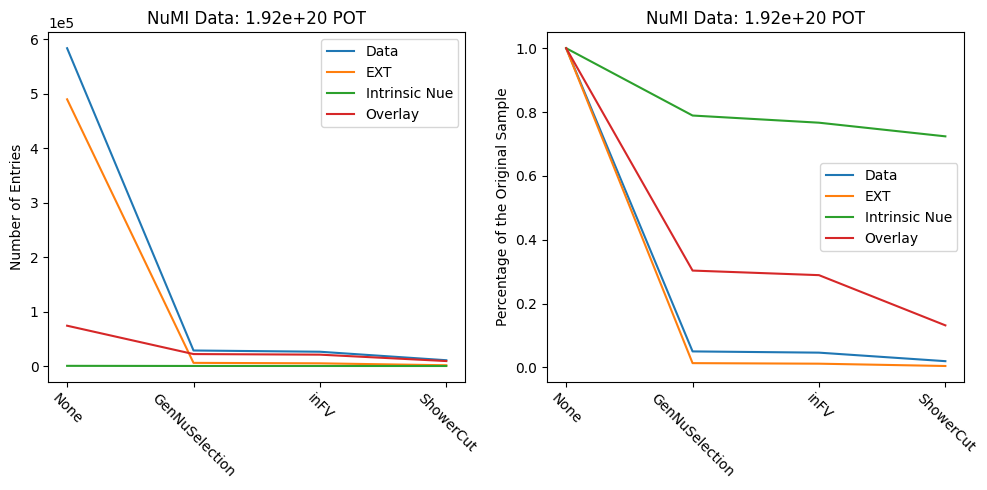

In [5]:
# define global variables
count = 0
throughout_the_cuts_nentries_data = []
throughout_the_cuts_nentries_ext = []
throughout_the_cuts_nentries_intrinsic_nue = []
throughout_the_cuts_nentries_overlay = []
throughout_the_cuts_nentries_x = []
throughout_the_cuts_nentries_label = []

# apply the cuts, make the stacked histograms, make other plots
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('None', df_data_original, df_ext_original, df_intrinsic_nue_original, df_overlay_original, count)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('GenNuSelection', df_data, df_ext, df_intrinsic_nue, df_overlay, count)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('inFV', df_data, df_ext, df_intrinsic_nue, df_overlay, count)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('ShowerCut', df_data, df_ext, df_intrinsic_nue, df_overlay, count)

# plot the number of entries after applying the cuts
plot_nentries(throughout_the_cuts_nentries_data, throughout_the_cuts_nentries_ext, throughout_the_cuts_nentries_intrinsic_nue, throughout_the_cuts_nentries_overlay, throughout_the_cuts_nentries_x, throughout_the_cuts_nentries_label)

## BDT 1 (nue+nuebar)

In [11]:
# ================================ #
#                                  #
#   KEEP THIS BLOCK COLLAPSED!!!   #
#                                  #
# ================================ #

def split_train_val_test(df,tag):
    
    # test = 1/3 of the sample
    # validation = 1/6 of the sample
    # training = 1/2 of the sample
    
    df_test = df.iloc[(df.index % 3 == 0).astype(bool)].reset_index(drop=True)
    df_train = df.iloc[(df.index % 3 != 0).astype(bool)].reset_index(drop=True)
    
    df_val = df_train.iloc[(df_train.index % 4 == 0).astype(bool)].reset_index(drop=True)
    df_train = df_train.iloc[(df_train.index % 4 != 0).astype(bool)].reset_index(drop=True)
    
    return df_train, df_val, df_test

def associate_variables(df_sig,df_bkg):

    df_sig = shuffle(df_sig).reset_index(drop=True)[variables_w]
    df_bkg = shuffle(df_bkg).reset_index(drop=True)[variables_w]

    # true label, 1=signal, 0=background
    df_sig.loc[:,'Y'] = 1
    df_bkg.loc[:,'Y'] = 0

    df = shuffle(pd.concat([df_sig,df_bkg]),random_state=1).reset_index(drop=True)

    x = df[df.columns[:-2]] # removes weight and Y for training
    y = df['Y']
    w = df['weight']

    return df, x, y, w

def plot_auc_error(model, n_estimators, auc_train, auc_val, error_train, error_val):
    plt.close()
    plt.figure(figsize=(15,5))

    plt.subplot(121)
    plt.plot(range(0,n_estimators), auc_train, c='blue', label='train')
    plt.plot(range(0,n_estimators), auc_val, c='orange', label='validation')
    ymin = min(min(auc_train),min(auc_val))
    ymax = max(max(auc_train),max(auc_val))
    plt.ylabel('AUC')
    plt.xlabel('Estimators')
    plt.ylim(ymin, ymax)
    plt.vlines(model.best_iteration, ymin=ymin, ymax=ymax, ls='--', color='red', label='best iteration', alpha=0.5)
    plt.legend(loc='best', prop={'size': legend_size})

    plt.subplot(122)
    plt.plot(range(0,n_estimators), error_train, c='blue', label='train')
    plt.plot(range(0,n_estimators), error_val, c='orange', label='validation')
    ymin = min(min(error_train),min(error_val))
    ymax = max(max(error_train),max(error_val))
    plt.ylabel('Classification Error')
    plt.xlabel('Estimators')
    plt.ylim(ymin, ymax)
    plt.vlines(model.best_iteration, ymin=ymin, ymax=ymax, ls='--', color='red', label='best iteration', alpha=0.5)
    plt.legend(loc='best', prop={'size': legend_size})
    
    plt.show()
    
def plot_important_features(features, feature_importances_, number, name, file):
    
    plt.close()
    plt.figure(figsize=(8,5))
    
    zipped = zip(features, feature_importances_)
    zipped_sort = sorted(zipped, key = lambda x:x[1], reverse=True)
    zipped_sort_reduced = zipped_sort[:number]
    
    res = [[ i for i, j in zipped_sort_reduced], 
           [ j for i, j in zipped_sort_reduced]]
    red_features = res[0]
    red_importances = res[1]
    
    plt.barh(range(len(red_importances)), red_importances, align='center')
    plt.yticks(np.arange(len(red_features)), red_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Top %i features"%(number))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
    plt.tight_layout()
    plt.show()
    
    return red_features

def plot_bdt_score(model, df_signal_train, df_signal_test, df_background_train, df_background_test, variables):
    
    pred_sig_train = model.predict_proba(df_signal_train[variables])[:,1] # column 1=success, 0=fail
    pred_sig_test = model.predict_proba(df_signal_test[variables])[:,1]
    pred_bkg_train = model.predict_proba(df_background_train[variables])[:,1]
    pred_bkg_test = model.predict_proba(df_background_test[variables])[:,1]
    
    plt.close()
    plt.figure(figsize=(14,4))
    nbins=50
    xrange=(0,1)

    plt.subplot(121)
    plt.hist(pred_sig_train, weights=df_signal_train['weight'], bins=nbins, range=xrange, density=True, color='red', alpha=0.5, label='Sig train (pdf)')
    plt.hist(pred_bkg_train, weights=df_background_train['weight'], bins=nbins, range=xrange, density=True, color='blue', alpha=0.5, label='Bkg train (pdf)')

    hist_sig_test, bins1, _1 = plt.hist(pred_sig_test, weights=df_signal_test['weight'], bins=nbins, range=xrange, density=True, alpha=0)
    mid=0.5*(bins1[1:] + bins1[:-1])
    plt.errorbar(x=mid, y=hist_sig_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='firebrick', label='Sig test (pdf)', fmt='o')

    hist_bkg_test, bins1, _1 = plt.hist(pred_bkg_test, weights=df_background_test['weight'], bins=nbins, range=xrange, density=True, alpha=0)
    mid=0.5*(bins1[1:] + bins1[:-1])
    plt.errorbar(x=mid, y=hist_bkg_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='navy', label='Bkg test (pdf)', fmt='o')

    plt.xlim(xrange)
    plt.xlabel('BDT score')
    plt.legend(loc='best', prop={'size': legend_size})

    plt.subplot(122)
    plt.hist(pred_sig_train, weights=df_signal_train['weight'], bins=nbins, range=xrange, color='red', alpha=0.5, label='Sig train')
    plt.hist(pred_bkg_train, weights=df_background_train['weight'], bins=nbins, range=xrange, color='blue', alpha=0.5, label='Bkg train')

    hist_sig_test, bins1, _1 = plt.hist(pred_sig_test, weights=df_signal_test['weight'], bins=nbins, range=xrange, alpha=0)
    mid=0.5*(bins1[1:] + bins1[:-1])
    plt.errorbar(x=mid, y=hist_sig_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='firebrick', label='Sig test', fmt='o')

    hist_bkg_test, bins1, _1 = plt.hist(pred_bkg_test, weights=df_background_test['weight'], bins=nbins, range=xrange, alpha=0)
    mid=0.5*(bins1[1:] + bins1[:-1])
    plt.errorbar(x=mid, y=hist_bkg_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='navy', label='Bkg test', fmt='o')

    plt.xlim(xrange)
    plt.xlabel('BDT score')
    plt.legend(loc='best', prop={'size': legend_size})
    plt.show()
    
def plot_efficiency_purity(df, POT_goal):
    
    step = 0.01
    
    bdt_var_min = 0 # don't touch
    bdt_var_max = 1 # don't touch
    
    # create arrays
    h_eff = []  # efficiency
    h_eff_x = []
    h_pur = []  # purity
    h_pur_x = []
    
    # loop over bdt variable, from 0 to 1 in steps defined above
    var = bdt_var_min
    while(var <= bdt_var_max):
        
        # --- calculate efficiency for our BDT
        
        df_eff_num = df[((df.truth_nuPdg==12) | (df.truth_nuPdg==-12)) &   # true nue+antinue
                       (df.truth_isCC==1) &                                # true cc interaction
                       (df.truth_vtxInside==1) &                           # true vtx in active volume
                       (df.bdt_score>var)]                                 # bdt score above cut
        df_eff_num = apply_gen_nu_selection(df_eff_num)                    # pass GenNuSelection
        
        df_eff_den = df[((df.truth_nuPdg==12) | (df.truth_nuPdg==-12)) &   # true nue+antinue
                       (df.truth_isCC==1) &                                # true cc interaction
                       (df.truth_vtxInside==1)]                            # true vtx in active volume
        
        if(len(df_eff_den)!=0):
            h_eff.append(len(df_eff_num)/len(df_eff_den))
            h_eff_x.append(var)
        
        # --- calculate purity for our BDT
        
        df_pur_num = df[((df.truth_nuPdg==12) | (df.truth_nuPdg==-12)) &   # true nue+antinue
                       (df.truth_isCC==1) &                                # true cc interaction
                       (df.truth_vtxInside==1) &                           # trut vtx in active volume
                       (df.bdt_score>var)]                                 # bdt score above cut
        
        df_pur_den = df[df.bdt_score>var]                                  # bdt score above cut
        
        if(len(df_pur_den)!=0):
            h_pur.append(len(df_pur_num)/len(df_pur_den))
            h_pur_x.append(var)        
            
        # --- calculate efficiency and purity if we use the wirecell definition of nue+nuebar
        
        #df_eff_num = 
        
        # --- update variable "var"
        var = var + step
        
    # --- now that we have the arrays, let's plot them :)
    plt.close()
    plt.figure(figsize=(8,5))
    plt.plot(h_eff_x, h_eff, c='blue', label='Efficiency')
    plt.plot(h_pur_x, h_pur, c='orange', label='Purity')
    plt.grid()
    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.xlabel('BDT score')
    plt.legend(loc='best', prop={'size': legend_size})
    plt.tight_layout()
    plt.show()
    


Defining signal and background:

   > Entries are either signal or background. Good job splitting them!

Creating validation, testing, and training:

   > Signal and background perfectly splitted into training, validation and testing. Good job!

Starting BDT training:

[0]	validation_0-auc:0.78754	validation_0-error:0.09967	validation_1-auc:0.77265	validation_1-error:0.09799


/home/marinaguzzo/miniconda3/envs/python3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[100]	validation_0-auc:0.96522	validation_0-error:0.03529	validation_1-auc:0.95992	validation_1-error:0.03501
[176]	validation_0-auc:0.96782	validation_0-error:0.03470	validation_1-auc:0.96255	validation_1-error:0.03465

Calculating BDT score:

...done!

Making plots:



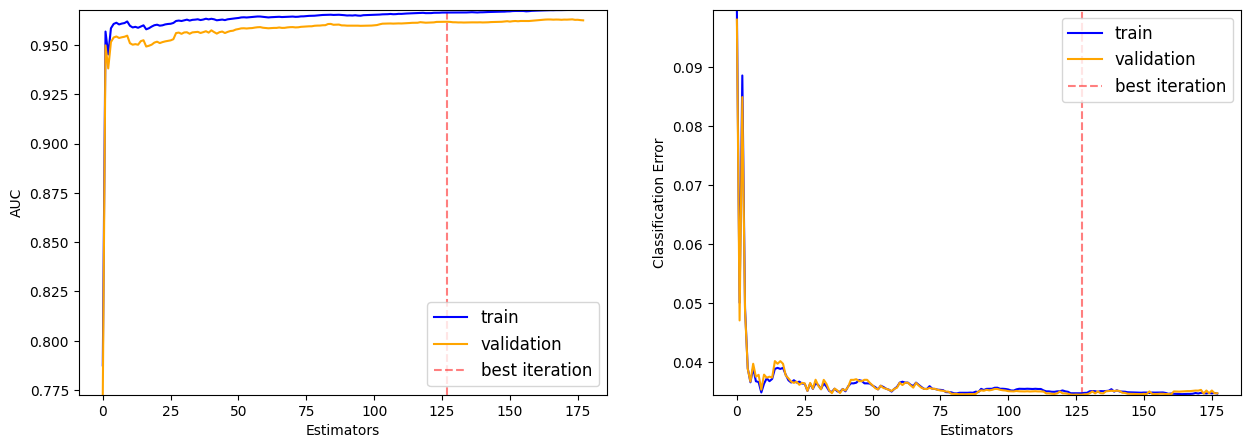

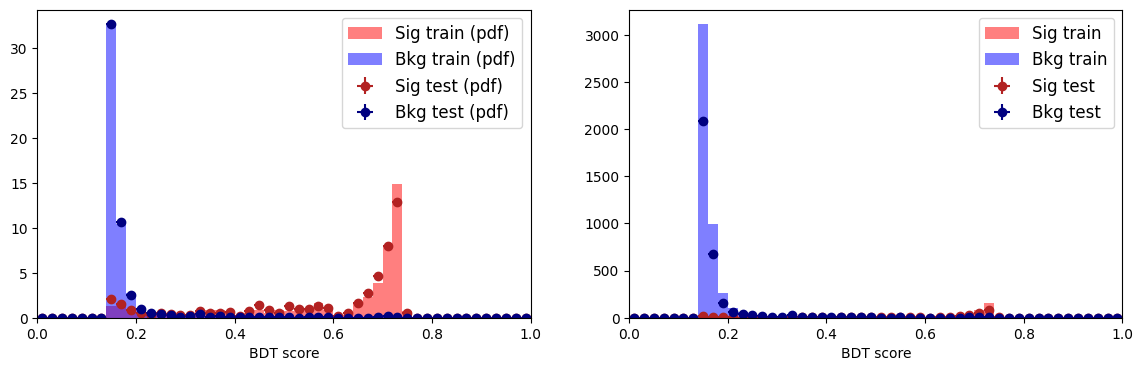

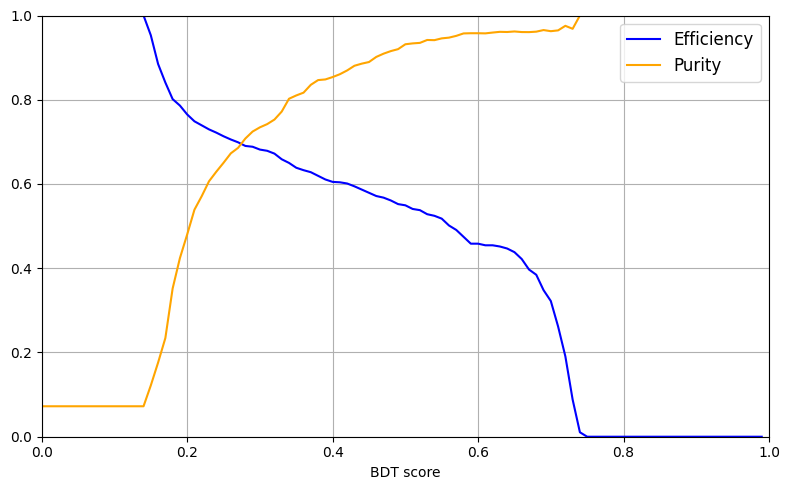

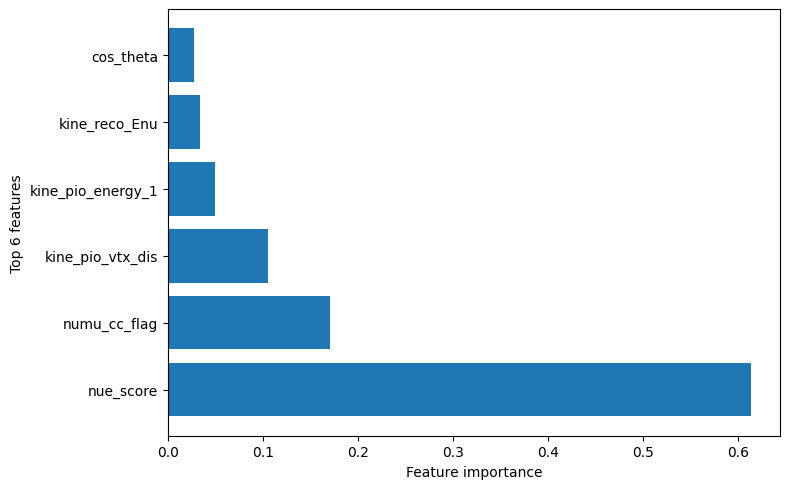

In [12]:
# ================= #
#                   #
#   BDT DATAFRAME   #
#                   #
# ================= #

df_bdt = pd.concat([df_intrinsic_nue,df_overlay], ignore_index=True) # merge intrinsic nue + overlay for a better nue/antinue stat

# ================================ #
#                                  #
#   DEFINE SIGNAL AND BACKGROUND   #
#                                  #
# ================================ #

print('\n\033[1m' + "Defining signal and background:" + '\033[0m\n')

def isSignal(df):
    df_ = df[((df.truth_nuPdg==12) & (df.truth_isCC==1)) | ((df.truth_nuPdg==-12) & (df.truth_isCC==1))] # nueCC or antinueCC
    df_ = df_[df_.dist_vtx<1] # good vertex reconstruction, less than 1 cm apart
    df_ = notCosmic(df_) #good event reconstruction, not labelled as cosmic
    return df_

df_signal = isSignal(df_bdt)
df_background = delete_dataframe(df_bdt,df_signal) # background is everything that is not signal

if((len(df_signal)+len(df_background))!=(len(df_bdt))): print('   > Ooops! Check your signal/background definition!')
else: print('   > Entries are either signal or background. Good job splitting them!')
    
# ============================================ #
#                                              #
#   CREATE VALIDATION, TESTING, AND TRAINING   #
#                                              #
# ============================================ #

print('\n\033[1m' + "Creating validation, testing, and training:" + '\033[0m\n')

variables_w = ['cos_theta', 'kine_reco_Enu', 'kine_pio_vtx_dis', 'kine_pio_energy_1', 'numu_cc_flag', 'nue_score', 'weight'] # keep 'weight' as the last one
variables = ['cos_theta', 'kine_reco_Enu', 'kine_pio_vtx_dis', 'kine_pio_energy_1', 'numu_cc_flag', 'nue_score']

# --- splits df_signal and df_background into train, validation, and testing dataframes according to the
# --- proportion defined in the function split_train_val_test

df_signal_train, df_signal_val, df_signal_test = split_train_val_test(df_signal, 'Signal')
df_background_train, df_background_val, df_background_test = split_train_val_test(df_background, 'Background')

# --- merges everything together to recover a single dataframe for training, validation, and testing
# --- each of those dataframes will have the same proportion of signal and background, defined in
# --- the function split_train_test

df_train, x_train, y_train, w_train = associate_variables(df_signal_train,df_background_train)
df_val, x_val, y_val, w_val = associate_variables(df_signal_val,df_background_val)
df_test, x_test, y_test, w_test = associate_variables(df_signal_test,df_background_test)

# --- check if you did the correct splitting

n_sig = len(df_signal)
n_bkg = len(df_background)

n_train = len(df_train)
n_val = len(df_val)
n_test = len(df_test)

if((n_train+n_val+n_test)!=(n_sig+n_bkg)): print('   > Ooops!')
else: print('   > Signal and background perfectly splitted into training, validation and testing. Good job!')
    
# ================ #
#                  #
#   BDT TRAINING   #
#                  #
# ================ #

print('\n\033[1m' + "Starting BDT training:" + '\033[0m\n')

use_label_encoder=False # removes warning message because XGBClassifier won't be used in future releases

model = XGBClassifier(n_estimators=300,                   # maximum number of rounds    300
                      max_depth=3,                        # number of cuts              6
                      scale_pos_weight = 1,               # sum(df_bkg_train.weight) / sum(df_sig_train.weight) (you should change it manually for your case)
                      learning_rate=0.01,                 # steps   0.05
                      objective='binary:logistic',        # bdt score 0-1
                      colsample_bytree=0.8)

                                                                # understand the parameters: https://xgboost.readthedocs.io/en/latest/python/python_api.html
model.fit(x_train,                                              # feature matrix
          y_train,                                              # labels (Y=1 signal, Y=0 background)
          sample_weight=w_train,                                # instance weights
          eval_set = [(x_train,y_train), (x_val,y_val)],        # a list of (X,y) tuple pairs to use as validation sets ---> validation_0=train, validation_1=validation
          sample_weight_eval_set = [w_train, w_val],            # list of arrays storing instances weights for the i-th validation set
          eval_metric = ['auc', 'error'],                       # list of parameters under eval_metric: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
          early_stopping_rounds=50,                             # validation metric needs to improve at least once in every early_stopping_rounds round(s)
          verbose=100)

results = model.evals_result()                            # takes the results from the BDT training above
n_estimators = len(results['validation_0']['error'])      # number of rounds used for the BDT training
auc_train = results['validation_0']['auc']                # subsample: auc for training
auc_val = results['validation_1']['auc']                  # subsample: auc for validation
error_train = results['validation_0']['error']            # subsample: error for training
error_val = results['validation_1']['error']              # subsample: error for validation

# ================================================= #
#                                                   #
#   CALCULATE BDT SCORE IN OUR ORIGINL DATAFRAMES   #
#                                                   #
# ================================================= #

print('\n\033[1m' + "Calculating BDT score:" + '\033[0m\n')

df_overlay.loc[:,'bdt_score'] = model.predict_proba(df_overlay[variables])[:,1]
df_intrinsic_nue.loc[:,'bdt_score'] = model.predict_proba(df_intrinsic_nue[variables])[:,1]
df_ext.loc[:,'bdt_score'] = model.predict_proba(df_ext[variables])[:,1]
df_data.loc[:,'bdt_score'] = model.predict_proba(df_data[variables])[:,1]

print('...done!')

# ===================================== #
#                                       #
#   MAKE PLOTS AFTER THE BDT TRAINING   #
#                                       #
# ===================================== #

print('\n\033[1m' + "Making plots:" + '\033[0m\n')

plot_auc_error(model, n_estimators, auc_train, auc_val, error_train, error_val)
plot_bdt_score(model, df_signal_train, df_signal_test, df_background_train, df_background_test, variables)
plot_efficiency_purity(df_overlay, POT_data)

list_feat = plot_important_features(variables_w[:-1], model.feature_importances_, 6, 'NC', 'important_features_bdt1')
